In [25]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from yellowbrick.classifier import ConfusionMatrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [2]:
from sklearn.feature_selection import VarianceThreshold, RFE

### Preprocessing

In [3]:
census = pd.read_csv('/home/tuts/data/mldsfromatoz/census.csv')

In [4]:
X_cols = list(census.columns)
X_cols.remove("income")

In [5]:
X = census[X_cols]
y = census.income

#### Encoding

In [6]:
def encode_cols(df):
    encoders = list()
    for col in df.columns:
        l = LabelEncoder()
        l.fit(df[col])
        encoders.append(l)
        df[col] = l.transform(df[col])
    return encoders


encode_cols(X)

/tmp/ipykernel_9495/1146228957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = l.transform(df[col])


[LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder()]

#### Scaling

In [7]:
mnmx = MinMaxScaler()
X_scaled = mnmx.fit_transform(X)

### Feature selection with variance

In [8]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.299727,0.483612,0.485005,0.686547,0.605379,0.435306,0.469481,0.289272,0.916464,0.669205,0.055095,0.022564,0.423419,0.895582
std,0.189382,0.181995,0.279437,0.258018,0.171515,0.251037,0.302061,0.321354,0.212201,0.470506,0.197460,0.110512,0.130581,0.190824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.152778,0.500000,0.249272,0.600000,0.533333,0.333333,0.214286,0.000000,1.000000,0.000000,0.000000,0.000000,0.419355,0.951220
50%,0.277778,0.500000,0.478034,0.733333,0.600000,0.333333,0.500000,0.200000,1.000000,1.000000,0.000000,0.000000,0.419355,0.951220
75%,0.430556,0.500000,0.715434,0.800000,0.733333,0.666667,0.714286,0.600000,1.000000,1.000000,0.000000,0.000000,0.473118,0.951220
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
variances = pd.DataFrame(X_scaled).var()

In [10]:
threshold = 0.05

vt = VarianceThreshold(threshold=threshold)

X_vtt = vt.fit_transform(X_scaled)

X_vtt.shape

(32561, 6)

In [11]:
vt.variances_

array([0.03586443, 0.03312115, 0.07808264, 0.06657104, 0.02941639,
       0.06301762, 0.09123817, 0.10326534, 0.04502805, 0.2213695 ,
       0.03898928, 0.01221246, 0.0170508 , 0.03641266])

In [12]:
census.columns[np.where(vt.variances_ > threshold)]

Index(['final-weight', 'education', 'marital-status', 'occupation',
       'relationship', 'sex'],
      dtype='object')

In [13]:
census_filtered = census.drop(
    columns=census.columns[np.where(vt.variances_ < threshold)], 
    axis=1
)

census_filtered

,final-weight,education,marital-status,occupation,relationship,sex,income
0,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,<=50K
1,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,<=50K
2,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,<=50K
3,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,<=50K
4,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,<=50K
...,...,...,...,...,...,...,...
32556,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,Female,<=50K
32557,154374,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,Male,>50K
32558,151910,HS-grad,Widowed,Adm-clerical,Unmarried,Female,<=50K
32559,201490,HS-grad,Never-married,Adm-clerical,Own-child,Male,<=50K


In [14]:
encode_cols(census_filtered)

[LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder()]

In [15]:
y = census_filtered.income

In [17]:
Xcf = pd.get_dummies(census_filtered.drop('income', axis=1))
Xcf_scaled = mnmx.fit_transform(Xcf)
Xcf_tr, Xcf_t, ycf_tr, ycf_t = train_test_split(Xcf_scaled, y, random_state=42, test_size=.2)

X_tr, X_t, y_tr, y_t = train_test_split(X_scaled, y, random_state=42, test_size=.2)

In [21]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=500)
rf.fit(Xcf_tr, ycf_tr)
preds_cf = rf.predict(Xcf_t)

rf = RandomForestClassifier(criterion='entropy', n_estimators=500)
rf.fit(X_tr, y_tr)
preds = rf.predict(X_t)

In [23]:
print(classification_report(ycf_t, preds_cf))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4942
           1       0.56      0.52      0.54      1571

    accuracy                           0.79      6513
   macro avg       0.70      0.69      0.70      6513
weighted avg       0.78      0.79      0.78      6513



In [24]:
print(classification_report(y_t, preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.75      0.64      0.69      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.79      0.80      6513
weighted avg       0.86      0.86      0.86      6513



### Feature selection with Feature Importance (RF)

In [26]:
ext = ExtraTreesClassifier()
ext.fit(X_scaled, y)

feature_importances = ext.feature_importances_

In [28]:
feature_importances

array([0.14914589, 0.04387814, 0.15786988, 0.0355435 , 0.08393635,
       0.07367383, 0.07414015, 0.08624416, 0.01484926, 0.02682048,
       0.11057877, 0.03392403, 0.09210386, 0.01729171])

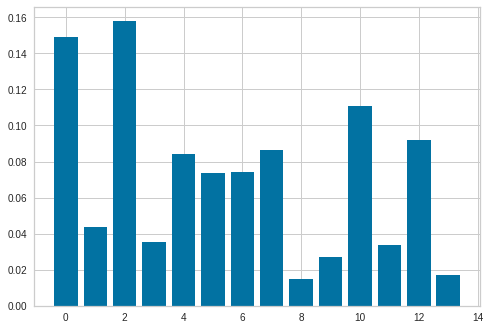

In [32]:
plt.bar(x=range(len(feature_importances)), height=feature_importances);

In [45]:
list(np.where(feature_importances > 0.04)[0])

[0, 1, 2, 4, 5, 6, 7, 10, 12]

In [47]:
X_ext_filt = X_scaled[:, list(np.where(feature_importances > 0.04)[0])]